# Sentiment Analysis on Twiter data on Stocks

In [1]:
import numpy as np
import pandas as pd
import pylab as plt
import json, nltk
import re

data_dir = '../data/'

In [2]:
def load_data():
    with open(data_dir+'pr_06_twits.json', 'r') as f:
        twits = json.load(f)
    df = pd.DataFrame(twits['data'])
    return df
    
data = load_data()

In [3]:
print (f"data shape:{data.shape}")
data.head(2)

data shape:(1548010, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,2,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,1,2018-07-01T00:00:42Z


In [4]:
# cut the data short to make learning faster keep only 8010 of them
#random_indices = np.random.choice(range(df.shape[0]), size=8010)
#df = df.loc[random_indices]
df = data.loc[:10000]

In [5]:
print (f" new data shape:{df.shape}")
df.head(2)

 new data shape:(10001, 3)


,message_body,sentiment,timestamp
0,$FITB great buy at 26.00...ill wait,2,2018-07-01T00:00:09Z
1,@StockTwits $MSFT,1,2018-07-01T00:00:42Z


In [6]:
def preprocess(message):    
    text = message.lower()                   # Lowercase the twit message
    text = re.sub(r'https?://\S+', ' ', text)# Replace URLs with a space
    text = re.sub(r'\$\S+', ' ', text)       # Replace ticker symbols with a space
    text = re.sub(r'\@\S+', ' ', text)       # Replace StockTwits usernames with a space.
    text = re.sub(r'[^a-zA-Z]', ' ', text)   # Replace everything not a letter with a space
    
    # Tokenize
    tokens = nltk.tokenize.word_tokenize(text)

    # Lemmatize words using the WordNetLemmatizer. You can ignore any word that is not longer than one character.
    wnl = nltk.stem.WordNetLemmatizer()
    tokens = [wnl.lemmatize(token) for token in tokens if len(token) > 1]
    
    return tokens

df['message_tokenized'] = df["message_body"].apply(preprocess)

<ipython-input-6-1999f57a38e0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['message_tokenized'] = df["message_body"].apply(preprocess)


In [7]:
df.head(2)

,message_body,sentiment,timestamp,message_tokenized
0,$FITB great buy at 26.00...ill wait,2,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]"
1,@StockTwits $MSFT,1,2018-07-01T00:00:42Z,[]


In [8]:
from collections import Counter

"""
Create a vocabulary by using Bag of words
"""
tokenized_words = [word for twit in df.message_tokenized for word in twit]
bow = Counter(tokenized_words)

In [9]:
print(bow.most_common(3))

[('the', 2590), ('to', 2458), ('is', 2191)]


In [10]:
bow.most_common(15)

[('the', 2590),
 ('to', 2458),
 ('is', 2191),
 ('for', 1966),
 ('on', 1760),
 ('of', 1522),
 ('in', 1418),
 ('and', 1297),
 ('this', 1268),
 ('it', 1113),
 ('will', 833),
 ('are', 797),
 ('at', 775),
 ('short', 760),
 ('up', 718)]

In [11]:
def remove_words(bow, low_cutoff=1e-5, high_cutoff=15):
    # remove the words which are outside the cutoff range
    # they usually are too common or too rare to make any big impact on the analysis
    total_cnt = sum(bow.values())
    
    freqs = dict(bow)
    for key in freqs:
        freqs[key] = freqs[key]/total_cnt
        
    K_most_common = [word[0] for word in bow.most_common(high_cutoff)]
    
    filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
    
    return freqs, filtered_words


In [12]:
freqs, filtered_words= remove_words(bow)

In [13]:
def prepare_vocab_dict(filtered_words):
    # A dictionary for the `filtered_words`.
    vocab = {word:idx+1 for idx, word in enumerate(filtered_words)}
    # reverse the vocab dictionary
    id2vocab = {idx:word for word, idx in vocab.items()}
    return vocab, id2vocab

vocab, id2vocab = prepare_vocab_dict(filtered_words)

In [14]:
print ("Top 5 word to index items")
for item in list(vocab.items())[:5]:
    print (item)
    
print ("\nTop 5 index to words items")
for item in list(id2vocab.items())[:5]:
    print (item)


Top 5 word to index items
('great', 1)
('buy', 2)
('ill', 3)
('wait', 4)
('staanalystalert', 5)

Top 5 index to words items
(1, 'great')
(2, 'buy')
(3, 'ill')
(4, 'wait')
(5, 'staanalystalert')


In [15]:
def filter_twit(words, filtered_words):
     return [word for word in words if word in filtered_words]

tmp = df['message_tokenized'].values[50]
print (tmp)
filter_twit(tmp, filtered_words)

['how', 'expect', 'the', 'earnings']


['how', 'expect', 'earnings']

In [16]:
df['filtered'] = df['message_tokenized'].apply(filter_twit, filtered_words=filtered_words)

<ipython-input-16-987fad6bb275>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filtered'] = df['message_tokenized'].apply(filter_twit, filtered_words=filtered_words)


In [17]:
df.head(2)

,message_body,sentiment,timestamp,message_tokenized,filtered
0,$FITB great buy at 26.00...ill wait,2,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]","[great, buy, ill, wait]"
1,@StockTwits $MSFT,1,2018-07-01T00:00:42Z,[],[]


### Balancing the classes

In [18]:
print ( df.sentiment.unique() )
df['sentiment'] = df['sentiment']+2
print ( df.sentiment.unique() )

[ 2  1  0 -2 -1]
[4 3 2 0 1]


<ipython-input-18-a0a1ae79df60>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = df['sentiment']+2


In [19]:
def find_counts(df):
    df_counts =df.groupby("sentiment", axis=0).count()
    df_counts["ratio (pct)"] = 100*df_counts["message_body"]/sum(df_counts["message_body"])
    return df_counts

find_counts(df)

,message_body,timestamp,message_tokenized,filtered,ratio (pct)
sentiment,,,,,
0,902,902,902,902,9.019098
1,1127,1127,1127,1127,11.268873
2,4799,4799,4799,4799,47.985201
3,1806,1806,1806,1806,18.058194
4,1367,1367,1367,1367,13.668633


this means almost half of the tweets are neutral in the sentiment. a classic example of unbalanced data set. One way to treat this is to remove the neutral data so that the class becomes more or less neutral. Here we'll make the counts of sentiment 2 and sentiment 3 equal.

In [20]:
def balance_classes(df):
    delete_after = df[df['sentiment']==3].shape[0] 
    indices_to_delete = df[df['sentiment']==2].index.values[delete_after:]
    #indices_to_delete = np.random.choice(df[df['sentiment']==2].index.values,
    #                                     len(df[df['sentiment']==2].index.values)-val)
    df = df.drop(index=indices_to_delete, axis=0)
    return df
    
df = balance_classes(df)

In [21]:
find_counts(df)

,message_body,timestamp,message_tokenized,filtered,ratio (pct)
sentiment,,,,,
0,902,902,902,902,12.871005
1,1127,1127,1127,1127,16.081621
2,1806,1806,1806,1806,25.770548
3,1806,1806,1806,1806,25.770548
4,1367,1367,1367,1367,19.506279


In [22]:
# delete texts with zero length
df['counts'] = df.filtered.apply(len)
df.head()

,message_body,sentiment,timestamp,message_tokenized,filtered,counts
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]","[great, buy, ill, wait]",4
1,@StockTwits $MSFT,3,2018-07-01T00:00:42Z,[],[],0
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,"[staanalystalert, for, jefferies, maintains, w...","[staanalystalert, jefferies, maintains, with, ...",14
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z,"[heard, there, guy, who, know, someone, who, t...","[heard, there, guy, who, know, someone, who, t...",12
4,$AMD reveal yourself!,2,2018-07-01T00:02:13Z,"[reveal, yourself]","[reveal, yourself]",2


In [23]:
df = df[df['counts']>0]
df.head()

,message_body,sentiment,timestamp,message_tokenized,filtered,counts
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]","[great, buy, ill, wait]",4
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,"[staanalystalert, for, jefferies, maintains, w...","[staanalystalert, jefferies, maintains, with, ...",14
3,$AMD I heard there’s a guy who knows someone w...,3,2018-07-01T00:01:47Z,"[heard, there, guy, who, know, someone, who, t...","[heard, there, guy, who, know, someone, who, t...",12
4,$AMD reveal yourself!,2,2018-07-01T00:02:13Z,"[reveal, yourself]","[reveal, yourself]",2
5,$AAPL Why the drop? I warren Buffet taking out...,3,2018-07-01T00:03:10Z,"[why, the, drop, warren, buffet, taking, out, ...","[why, drop, warren, buffet, taking, out, his, ...",8


In [24]:
find_counts(df)

,message_body,timestamp,message_tokenized,filtered,counts,ratio (pct)
sentiment,,,,,,
0,890,890,890,890,890,13.165680
1,1112,1112,1112,1112,1112,16.449704
2,1676,1676,1676,1676,1676,24.792899
3,1726,1726,1726,1726,1726,25.532544
4,1356,1356,1356,1356,1356,20.059172


## Prepare input for Model
- convert the text entry to numerical values
- Pad the numerical values to a certain length
- convert the y labels to categorical 
- train, test, val split

In [46]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def text_to_numerics(text, vocab):
    return [vocab[word] for word in text]

def pad_list(lst, max_len):
    # pad a list with zeros at the end to make the length max_len
    lst = lst+[0]*(max_len-len(lst))
    return lst[:max_len]
    
def prepare_input_for_model(df):
    df['text_to_number'] = df['filtered'].apply(text_to_numerics, vocab=vocab)
    df["padded_x"] = df['text_to_number'].apply(pad_list, max_len=20)

    X = np.array(df["padded_x"].values)
    X = np.stack( X, axis=0 )
    
    y = df['sentiment'].values
    y = to_categorical(y)
    return (df, X, y)
    
def split_data(X, y):
    X_train_, X_val, y_train_, y_val = train_test_split(X, y, test_size=0.2)
    X_train, X_test, y_train, y_test = train_test_split(X_train_, y_train_, test_size=0.25)

    print (f"X_train.shape: {X_train.shape} y_train.shape:{y_train.shape}" )
    print (f"X_test.shape: {X_test.shape} y_test.shape:{y_test.shape}" )
    print (f"X_val.shape: {X_val.shape} y_val.shape:{y_val.shape}" )

    return X_train, X_test, X_val, y_train, y_test, y_val

(df, X, y) = prepare_input_for_model(df)
X_train, X_test, X_val, y_train, y_test, y_val =  split_data(X, y)


X_train.shape: (3050, 20) y_train.shape:(3050, 5)
X_test.shape: (1017, 20) y_test.shape:(1017, 5)
X_val.shape: (1017, 20) y_val.shape:(1017, 5)


## Model Training

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import preprocessing
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


In [36]:
def plot_history(history):
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.grid()
    plt.legend()

    plt.subplot(122)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.grid()
    plt.legend()

## Modeling for a binary classification
- remove the neutral tweets and relabel the 0 and 1 as 0 and 3 and 4 as 1

In [57]:
def prepare_input_for_binary_model(df):
    df = df[df['sentiment']!=2]
    # 0 for positive sentiment
    # 1 for negative sentiment
    df['sentiment_bin'] = df['sentiment'].apply(lambda x: int(x<2))

    X = np.array(df["padded_x"].values)
    X = np.stack( X, axis=0 )
    
    y = df['sentiment_bin'].values

    return (df, X, y)
    
(df, X, y) = prepare_input_for_binary_model(df)
X_train, X_test, X_val, y_train, y_test, y_val =  split_data(X, y_bin)

X_train.shape: (3050, 20) y_train.shape:(3050,)
X_test.shape: (1017, 20) y_test.shape:(1017,)
X_val.shape: (1017, 20) y_val.shape:(1017,)


In [58]:
df.head(2)

,message_body,sentiment,timestamp,message_tokenized,filtered,counts,text_to_number,padded_x,sentiment_bin
0,$FITB great buy at 26.00...ill wait,4,2018-07-01T00:00:09Z,"[great, buy, at, ill, wait]","[great, buy, ill, wait]",4,"[1, 2, 3, 4]","[1, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
2,#STAAnalystAlert for $TDG : Jefferies Maintain...,4,2018-07-01T00:01:24Z,"[staanalystalert, for, jefferies, maintains, w...","[staanalystalert, jefferies, maintains, with, ...",14,"[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...",0


In [65]:
def make_model_binary(X, y, vocab=vocab, embedding_length=10):
    model = Sequential()
    model.add(Embedding(len(vocab.items())+1, embedding_length, input_length=X.shape[1]))
    model.add(LSTM(6, bias_regularizer="l2", dropout=.1, recurrent_dropout=0.2, return_sequences=True))
    model.add(LSTM(6, bias_regularizer="l2", dropout=.1, recurrent_dropout=0.2))
    model.add(Dropout(.2))
    model.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=0.0001)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

model2 = make_model_binary(X_train, y_train)
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 20, 10)            39940     
_________________________________________________________________
lstm_6 (LSTM)                (None, 20, 6)             408       
_________________________________________________________________
lstm_7 (LSTM)                (None, 6)                 312       
_________________________________________________________________
dropout_6 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 7         
Total params: 40,667
Trainable params: 40,667
Non-trainable params: 0
_________________________________________________________________


In [69]:
history2 = model2.fit(X_train, y_train, epochs=10, verbose=1, batch_size=4,
                      validation_data=(X_val, y_val))

Epoch 1/20
382/382 [==============================] - 11s 28ms/step - loss: 0.3394 - accuracy: 0.9256 - val_loss: 0.6057 - val_accuracy: 0.7768
Epoch 2/20
382/382 [==============================] - 9s 25ms/step - loss: 0.3252 - accuracy: 0.9285 - val_loss: 0.6078 - val_accuracy: 0.7738
Epoch 3/20
382/382 [==============================] - 9s 24ms/step - loss: 0.3118 - accuracy: 0.9354 - val_loss: 0.6281 - val_accuracy: 0.7788
Epoch 4/20
382/382 [==============================] - 11s 28ms/step - loss: 0.3043 - accuracy: 0.9341 - val_loss: 0.6296 - val_accuracy: 0.7788
Epoch 5/20
382/382 [==============================] - 10s 27ms/step - loss: 0.2904 - accuracy: 0.9357 - val_loss: 0.6199 - val_accuracy: 0.7788
Epoch 6/20
382/382 [==============================] - 10s 26ms/step - loss: 0.2767 - accuracy: 0.9377 - val_loss: 0.6320 - val_accuracy: 0.7778
Epoch 7/20
382/382 [==============================] - 10s 26ms/step - loss: 0.2654 - accuracy: 0.9413 - val_loss: 0.6407 - val_accuracy: 0

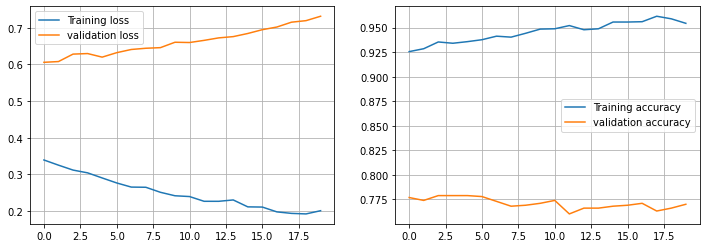

In [70]:
plot_history(history2)

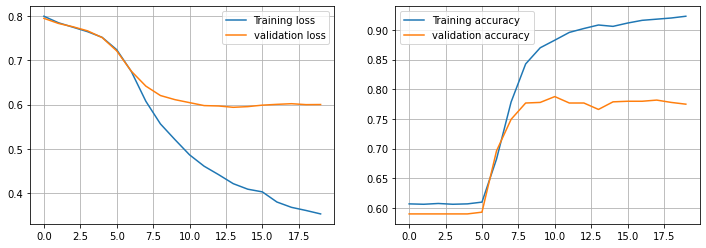

In [68]:
plot_history(history2)

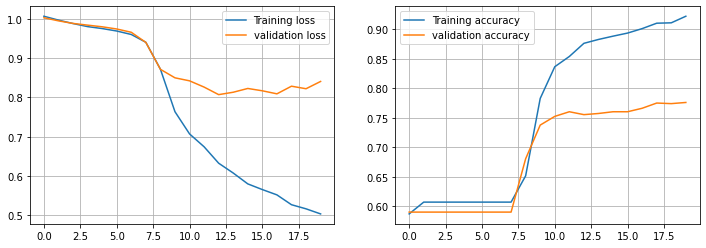

In [64]:
plot_history(history2)

In [50]:

text = "Google is working on self driving cars, I'm bullish on $goog"

tokens = preprocess(text)
tokens = [word for word in tokens if word in filtered_words]
tokens = [vocab[word] for word in tokens] 
X_input = pad_list(tokens, max_len=20)

In [53]:
model1.predict(X_input)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [ ]:
def predict(text, model, vocab):
    
    # TODO Implement
    tokens = preprocess(text)
    tokens = [word for word in tokens if word in filtered_words]
    tokens = [vocab[word] for word in tokens] 
    padded_tokens = pad_list(tokens, max_len=20)
    

    text_input = torch.tensor(tokens).unsqueeze(0)
    
    if train_on_gpu:
        text_input = text_input.cuda()
        model.cuda()
    # Get the NN output
    hidden = model.init_hidden(text_input.size(0))
    logps, _ = model.forward(text_input, hidden)
    # Take the exponent of the NN output to get a range of 0 to 1 for each label.
    pred = torch.exp(logps)
    
    return pred